# Machine Learning Assignment
Στο συγγεκριμένο notebook βρίσκονται οι ασκήσεις του μαθήματος "Μηχανική Μάθηση" της χρονιάς 2024-2025.

Το dataset που χρησιμοποίησα είναι το Wine Quality Dataset του πανεπιστημίου UC Irvine (https://archive.ics.uci.edu/dataset/186/wine+quality). Πρόκειται για ένα dataset με 11 features και 1 label, την ποιότητα του κρασιού, που είναι ένα σκορ από 1 εώς 10. Για τους σκοπούς της άσκησης, θα υποθέσουμε ότι το κάθε σκορ μπορεί να ανήκει σε μία από 5 κατηγορίες:

*   Κάκιστο (Very Bad. Score: 0-2)
*   Κακό (Bad. Score: 2-4)
*   Εντάξει (Alright. Score 4-6)
*   Καλό (Good. Score 6-8)
*   Άριστο (Excellent. Score 8-10)

Τα ερωτήματα είναι τεράστια για ένα notebook, οπότε αποφάσισα να τα χωρίσω ανά 2. Το συγκεκριμένο notebook θα έχει τα παρακάτω ερωτήματα:

1.   Principal Component Analysis (PCA)
2.   Least Squares

Στα υπόλοιπα αρχεία θα λυθούν τα θέματα με την ακόλουθη σειρά:

3.   Logistic Regression
4.   K Nearest Neighbors (KNN)
5.   Naive Bayes
6.   Multilayer Perceptron (MLP) in Pytorch
7.   Support Vector Machine (SVM)
8.   K Means

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/MLAssignment/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [ ]:
wines = pd.read_csv('winequality-red.csv', sep=';')

features = wines.drop("quality", axis=1)
label = wines["quality"]

X = np.array(features)
y = wines[["quality"]].to_numpy() #For shape (n,1)

# I am aware this method is not good for edge cases, but it is what it is

def classify(y):
    if y < 2.0:
        y = "Very Bad"
    elif y < 4.0:
        y = "Bad"
    elif y < 6.0:
        y = "Alright"
    elif y < 8.0:
        y = "Good"
    else:
        y = "Excellent"
    return y


y_classified = [classify(label) for label in y]

print(X.shape)

(1599, 11)


# 1) Principal Component Analysis (PCA)

In [ ]:
def eigsort(A):
    eigvals, U = np.linalg.eig(A)
    # sort eigenvalues in descending order
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    #re-arrange the eigenvectors
    U = U[:,order]
    return U, eigvals

In [ ]:
def pca_classic(X, M):

    #για κάθε στήλη του πίνακα X υπολογίστε το μέσο όρο, και αποθηκεύστε το σε διάνυσμα γραμμής
    mu = X.mean(axis=0).reshape( (1,-1) )

    #αφαιρέστε το μέσο όρο από τον πίνακα
    normalized_X = (X-mu)

    #υπολογίστε το Covariance matrix για τον πίνακα του προηγούμενου βήματος
    S = (1/X.shape[0]) * normalized_X.T.dot( normalized_X)

    #υπολογίστε τα ιδιοδιανύσματα και τις ιδιοτιμές του covariance πίνακα
    eigvectors, eigvals = eigsort( S )

    #κρατήστε στον πίνακα U τις πρώτες Μ στήλες των ιδιοδιανυσμάτων
    U = eigvectors[:,:M]
    #κρατήστε στον πίνακα Lambads τις πρώτες Μ ιδιοτιμές
    Lambdas = eigvals[:M]
    print( X.shape, U.shape, Lambdas.shape )

    #αποθηκεύστε το μετασχηματισμό Z = U * X ( προσέξτε τις διαστάσεις )
    #ο πίνακας U εφαρμόζεται στον κανονικοποιημένο πίνακα X και τον προβάλει
    #επάνω στα ιδιοδιανύσματα(μειωμένη διάσταση)
    Z = normalized_X.dot(U)
    return Z, U, Lambdas, mu

In [ ]:
M = 10
Z, eigvecs, eigvals, mu = pca_classic(X, M)
X_rec = Z.dot(eigvecs.T) + mu

print(X_rec)

(1599, 11) (11, 10) (10,)
[[7.40000025e+00 7.00000188e-01 1.52949468e-08 ... 3.51000133e+00
  5.60000343e-01 9.39999976e+00]
 [7.80000023e+00 8.80000175e-01 1.42028793e-08 ... 3.20000123e+00
  6.80000318e-01 9.79999978e+00]
 [7.80000033e+00 7.60000248e-01 4.00000202e-02 ... 3.26000175e+00
  6.50000453e-01 9.79999968e+00]
 ...
 [6.30000097e+00 5.10000739e-01 1.30000060e-01 ... 3.42000521e+00
  7.50001347e-01 1.09999990e+01]
 [5.89999975e+00 6.44999807e-01 1.19999984e-01 ... 3.56999864e+00
  7.09999648e-01 1.02000002e+01]
 [6.00000079e+00 3.10000600e-01 4.70000049e-01 ... 3.39000423e+00
  6.60001094e-01 1.09999992e+01]]


# 2) Least Squares

In [ ]:
def predict(X, theta): #Takes a row as input, then produces the expected y-hat value
    if theta.shape[0] - X.shape[1] == 1: #Is the bias term accounted for?
        X = np.hstack( [ np.ones( (X.shape[0],1) ), X ]  )
    return round(np.dot(X, theta)[0][0])

    '''
    Figured since the given data is integers, and we had an issue with the edge cases (1.9, 3.9) I should round the numbers. This increased the accuracy from around 64% to almost 73%
    '''

def normalize_features(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    return X_normalized

X_squares = normalize_features(X)
print(X_squares.shape)

(1599, 11)


# Gradient Descent

In [ ]:
m = X.shape[0]#total number of examples

X_GD = np.hstack( [ np.ones( (m,1) ), X_squares ]  )#add a column of 1s at the beginning
theta = np.zeros( (X_GD.shape[1],1) )#parameters theta are assigned to 0
iterations = 1000
alpha = 0.01#the learning rate

def computeCost( X, y, theta ):
    #Return: #Compute cost for Linear Regression

    m = X.shape[0]#number of training examples


    J = (1 / (2.0*m) ) * np.sum( ( ( np.dot(X,theta)-y)**2 ) )

    return J

def gradientDescent(X, y, theta, alpha, num_iters):

    m = X.shape[0]#number of training examples
    J_history = np.zeros( (num_iters,1) )
    accuracy = np.zeros((num_iters,1))

    for which_iter in range(num_iters):

        #calculate error
        error = ( np.dot(X,theta) ) - y

        #Changed the lab formula for variable features
        temp = []
        for i in range(theta.shape[0]):
          temp.append(theta[i] - ( alpha / m ) * np.sum( error * X[:,i].reshape( (-1,1) ) ))

        theta = np.array( temp )

        #Save the cost J in every iteration
        J_history[which_iter] = computeCost(X, y, theta)

        correct = 0
        total = X.shape[0]
        for row in range(total):
            y_hat = predict(np.array([X[row]]), theta)
            if y_classified[row] == classify(y_hat):
                correct += 1
        accuracy[which_iter] = correct / float(total)

    return ( J_history, theta, accuracy )

computeCost( X_GD, y, theta )

16.20825515947467

In [ ]:
J_history, new_theta, accuracy = gradientDescent( X_GD, y, theta, alpha, iterations )

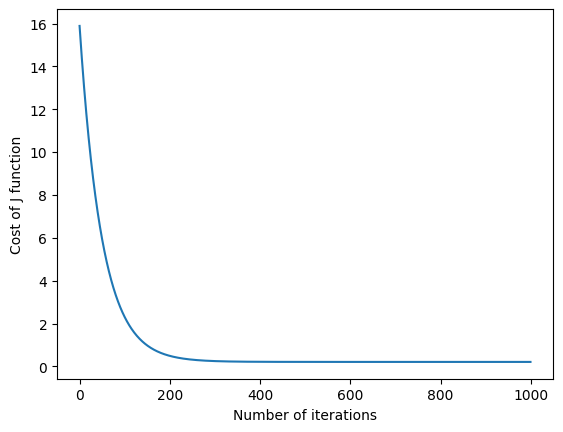

In [ ]:
plt.plot( np.arange(J_history.shape[0]), J_history )
plt.xlabel( 'Number of iterations' )
plt.ylabel( 'Cost of J function' )
plt.show()

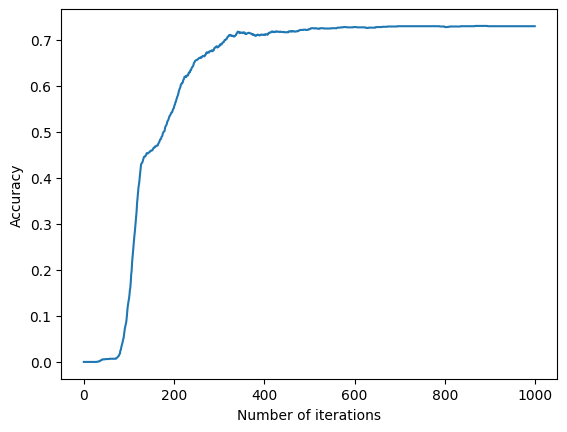

In [ ]:
plt.plot( np.arange(accuracy.shape[0]), accuracy )
plt.xlabel( 'Number of iterations' )
plt.ylabel( 'Accuracy' )
plt.show()

In [ ]:
accuracy[-1][0]

0.7298311444652908

# Normal Equation

In [ ]:
X_normal = np.hstack( [ np.ones( (X.shape[0],1) ), X_squares ]  )
t = y
w = np.linalg.solve( X_normal.T.dot(X_normal), X_normal.T.dot(t) )

correct = 0

for row in range(X_normal.shape[0]):
    y_hat = predict(np.array([X_normal[row]]), w)
    if y_classified[row] == classify(y_hat):
        correct += 1
accuracy_normal = correct / float(X_normal.shape[0])
print(accuracy_normal)

0.7267041901188243
